# Introducción.

La cátedra de Teoría de la Información ha proporcionado cuatro datasets analizando algo tan simple —y, paradójicamente, tan geopolíticamente condicionado por mapas y climas— como las temperaturas promedio de tres ciudades con condiciones meteorológicas (y políticas) bien distintas.

Previo al análisis de los datos, se realizará la importación de las librerías a usar, la carga de los datos y su limpieza.

Las tres ciudades cuyas temperaturas se analizarán se introducen por la cátedra de la siguiente manera:

- Quito: donde la temperatura no cambia ni aunque recen diez climas distintos.

- Melbourne: donde podés experimentar las cuatro estaciones antes del almuerzo.

- Oslo: donde el clima no se decide si quiere ser Siberia o un spa nórdico.

Brindando un poco de contexto geográfico, Quito es la capital de Ecuador, Melbourne es una ciudad de Australia y Oslo es la capital y ciudad más poblada de Noruega. Para poder tener en claro la distancia entre estos países, se invita a observar el siguiente mapa, en el que se encuentran coloreadas los tres países a analizar:

<img src="images/mapa.png" width="" align="" />

Habiendo introducido la tarea asignada y un poco de contexto geográfico, se realiza la tarea de preparar todo lo necesario para analizar los datos y resolver las consignas propuestas.

## Importación de Librerías.

Se importan las librerías necesarias que se utilizarán a lo largo del trabajo:

In [1]:
# Utilizada para la obtención de valores aleatorios.
import random

# Utilizada en la lectura de los datos.
import pandas as pd

# Utilizada en la creación de matrices.
import numpy as np

# Utilizadas para la visualización de los datos.
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de los Datos.

Se realiza la lectura y carga de los datasets:

In [2]:
# Datasets correspondientes a las temperaturas de Quito, Melbourne y Oslo, mencionados en la explicación.
dataset_raw_quito=pd.read_csv("temperature_Quito_celsius.csv")
dataset_raw_melbourne=pd.read_csv("temperature_Melbourne_celsius.csv")
dataset_raw_oslo=pd.read_csv("temperature_Oslo_celsius.csv")

# (Este dataset será usado e introducido recién en la parte 4).
dataset_raw_melbourne_ruidoso = pd.read_csv("temperature_Melbourne_celsius_ruidoso.csv")

## Limpieza de los Datos.

Se identificaron outliers en los datasets de Melbourne y Oslo, al igual que en el de Melbourne ruidoso (este último será introducido y utilizado recién en la parte 4).

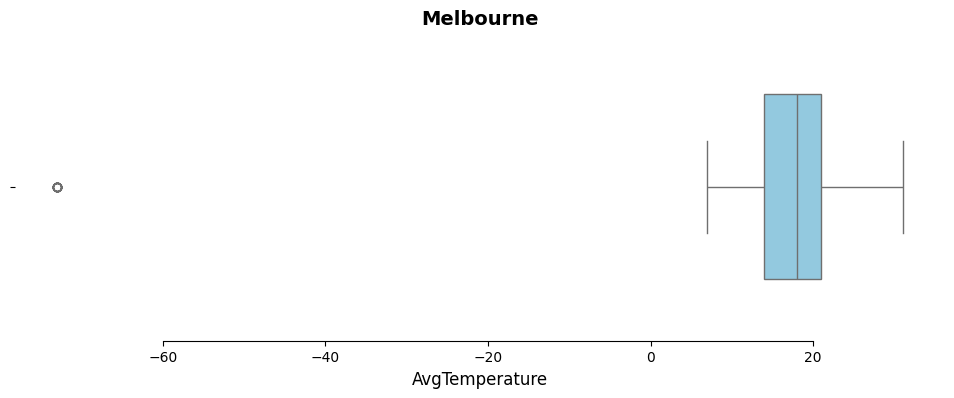

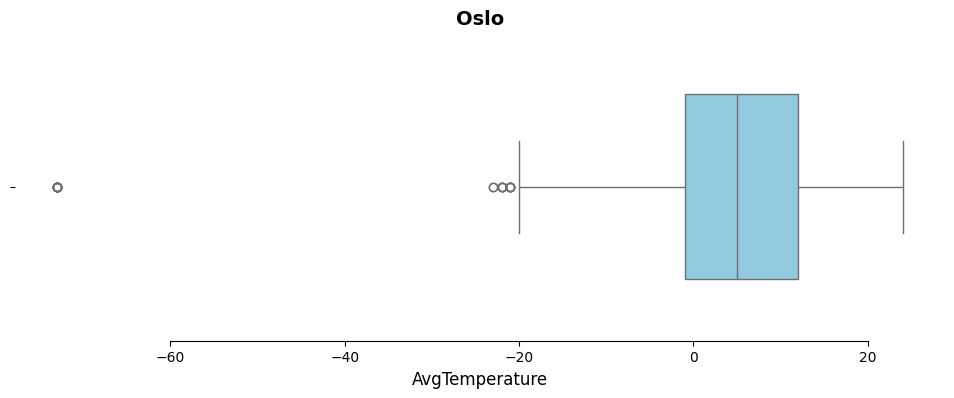

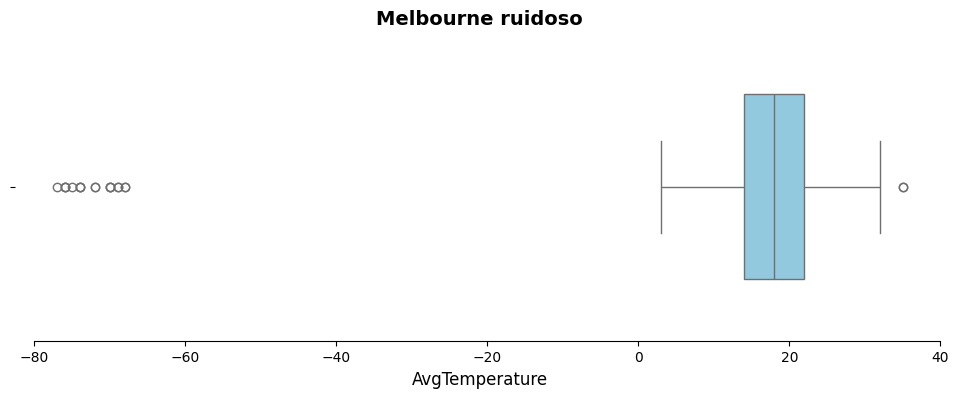

In [3]:
def mostrar_boxplot(dataset, x, title):
    plt.figure(figsize=(12, 4))
    sns.boxplot(x=dataset[x], color='skyblue', width=0.6)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(x, fontsize=12)
    sns.despine(offset=0, trim=True)
    plt.show()

mostrar_boxplot(dataset_raw_melbourne, "AvgTemperature", "Melbourne")
mostrar_boxplot(dataset_raw_oslo, "AvgTemperature", "Oslo")
mostrar_boxplot(dataset_raw_melbourne_ruidoso, "AvgTemperature", "Melbourne ruidoso")

En los dos primeros datasets, el valor de los outliers es el mismo: -73. Por otro lado, en el de Melbourne ruidoso, estos outliers varían entre -77.0 y -68.0. A destacar, en el dataset de Oslo figuran otros datos inferiores al bigote inferior de la caja, sin embargo, estos son datos inusuales, pero reales. Por consiguiente, permanecieron en el dataset.

Al momento de manejar estos datos, se evaluaron distintas alternativas, tales como:

- Eliminar todas las entradas del dataset en las que aparezca dicha temperatura. Sin embargo, esto implicaría, para mantener consistencia, eliminar dichos días también de los demás datasets. Y, al estar realizadas las mediciones por días, perderlas dificultaría la toma de estadísticas entre años.

- Imputar los datos, a partir de sus datos vecinos. En la mayoría de las ocasiones en las que aparece un outlier, lo hace entre dos valores cercanos entre sí, lo que facilite poder tomar una estimación de qué valor tendría que ocupar dicho lugar.

Se presenta a continuación una secuencia de datos del dataset de Melbourne en la que puede presenciarse lo mencionado:

In [4]:
print(dataset_raw_melbourne.loc[[1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471]])

      AvgTemperature
1450            20.0
1451            22.0
1452            22.0
1453           -73.0
1454           -73.0
1455            22.0
1456            22.0
1457            23.0
1458            24.0
1459           -73.0
1460           -73.0
1461            23.0
1462            23.0
1463            25.0
1464            26.0
1465            26.0
1466            25.0
1467            25.0
1468            23.0
1469            23.0
1470           -73.0
1471            27.0


Para imputar dichos datos, se obtuvieron sus correspondientes índices del dataset:

In [5]:
def get_indexes_outliers(dataset, min_range, max_range=None):

    # Si no se especifica un max_range, se usa un valor exacto.
    if max_range is None:
        return list(dataset[dataset["AvgTemperature"] == min_range].index)
    
    # Se busca por rangos.
    return list(dataset[(dataset["AvgTemperature"] >= min_range) & 
                       (dataset["AvgTemperature"] <= max_range)].index)

datos_basura_melbourne = get_indexes_outliers(dataset_raw_melbourne, -73.0)
datos_basura_oslo = get_indexes_outliers(dataset_raw_oslo, -73.0)
datos_basura_melbourne_ruidoso = get_indexes_outliers(dataset_raw_melbourne_ruidoso, -77.0, -68.0)

print("Indices de datos basura: ")
print(datos_basura_melbourne)
print(datos_basura_oslo)
print(datos_basura_melbourne_ruidoso)

Indices de datos basura: 
[1453, 1454, 1459, 1460, 1470, 2246, 2725, 2726, 2727, 2728, 2806, 2981, 3187, 4622, 4790, 5015, 5212]
[1453, 1454, 1459, 1460, 1470, 2725, 2726, 2727, 2728, 4622, 4723, 5212]
[1453, 1454, 1459, 1460, 1470, 2246, 2725, 2726, 2727, 2728, 2806, 2981, 3187, 4622, 4790, 5015, 5212]


Utilizando los anteriores índices, se completa el dato a partir de los datos anteriores, realizando una imputación por media móvil de orden 5 (es decir, se remplaza el outlier por el promedio de los cinco datos anteriores):

In [6]:
def imputar_dataset(indexes, dataset, orden=5):
    # Se realiza una copia para no modificar el dataset original.
    out = dataset.copy()
    for index in indexes:
        if index >= orden:
            out["AvgTemperature"][index] = round(out["AvgTemperature"][index - orden:index].mean())
    return out

cleaned_dataset_quito = dataset_raw_quito.copy() # Se redefine el nombre para mayor claridad.
cleaned_dataset_melbourne = imputar_dataset(datos_basura_melbourne, dataset_raw_melbourne)
cleaned_dataset_oslo = imputar_dataset(datos_basura_oslo, dataset_raw_oslo)
cleaned_dataset_melbourne_ruidoso = imputar_dataset(datos_basura_melbourne_ruidoso, dataset_raw_melbourne_ruidoso)

A continuación, se grafican nuevamente los boxplots con la finalidad de mostrar que los datos fueron efectivamente imputados:

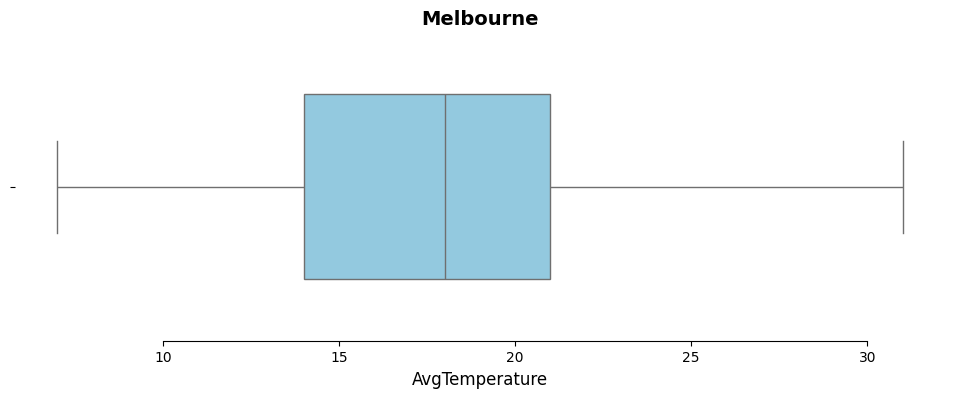

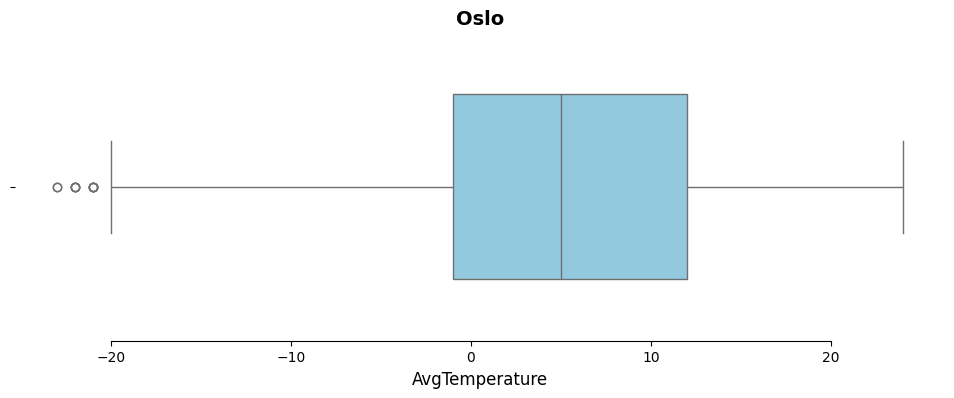

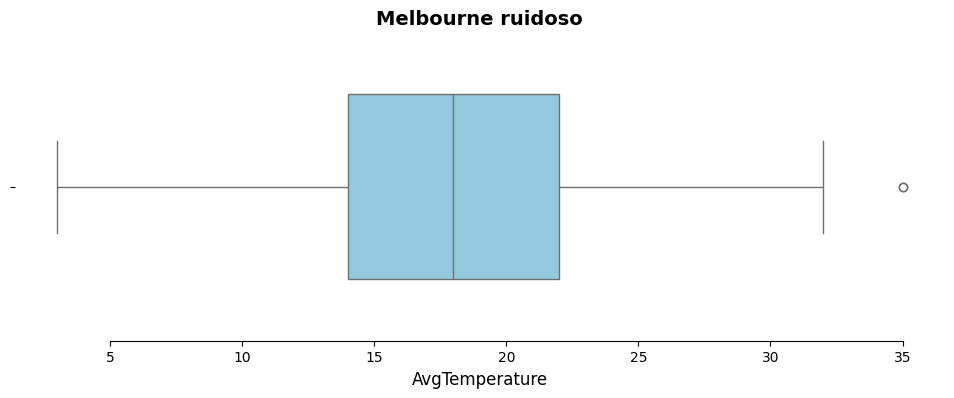

In [7]:
# Se observan nuevamente los boxplots con la finalidad de corroborar la limpieza de los datos.
mostrar_boxplot(cleaned_dataset_melbourne, "AvgTemperature", "Melbourne")
mostrar_boxplot(cleaned_dataset_oslo, "AvgTemperature", "Oslo")
mostrar_boxplot(cleaned_dataset_melbourne_ruidoso, "AvgTemperature", "Melbourne ruidoso")

Habiendo comprobado que los datos están limpios, se prosiguió con la resolución del trabajo práctico.

# Parte 1: Estadísticas para ingenieros que miran el cielo.

Dadas las señales de temperaturas diarias registradas durante cierto periodo en las tres ciudades anteriormente mencionadas, expresadas como valores enteros, en °C (grados centígrados), se pide:

## 1.1 Calcular la temperatura promedio y la desviación estándar para cada señal Si y analizar cómo se comportan estadísticamente.

Se realiza el cálculo de los promedios de las tres ciudades:

In [8]:
def calcular_promedio(dataset):
    suma = 0
    for temperature in dataset["AvgTemperature"]:
        suma = suma + temperature
    return suma / len(dataset["AvgTemperature"])

promedio_quito = calcular_promedio(cleaned_dataset_quito)
promedio_melbourne = calcular_promedio(cleaned_dataset_melbourne)
promedio_oslo = calcular_promedio(cleaned_dataset_oslo)

Y se realiza el cálculo de sus desviaciones estándar:

In [9]:
def calcular_desvio_estandar(dataset, promedio):
    suma = 0
    for temperature in dataset["AvgTemperature"]:
        suma += pow(temperature - promedio, 2)
    return np.sqrt(suma/len(dataset["AvgTemperature"]-1)) 

desvio_quito = calcular_desvio_estandar(dataset_raw_quito, promedio_quito)
desvio_melbourne = calcular_desvio_estandar(cleaned_dataset_melbourne, promedio_melbourne)
desvio_oslo = calcular_desvio_estandar(cleaned_dataset_oslo, promedio_oslo)

Los resultados obtenidos, redondeados a tres decimales, son los siguientes:

In [10]:
print("Resultados de Quito:")
print("Promedio: ", round(promedio_quito, 3))
print("Desviación estándar: ", round(desvio_quito, 3))
print("\nResultados de Melbourne:")
print("Promedio: ", round(promedio_melbourne, 3))
print("Desviación estándar: ", round(desvio_melbourne, 3))
print("\nResultados de Oslo:")
print("Promedio: ", round(promedio_oslo, 3))
print("Desviación estándar: ", round(desvio_oslo, 3))

Resultados de Quito:
Promedio:  13.604
Desviación estándar:  1.302

Resultados de Melbourne:
Promedio:  17.803
Desviación estándar:  4.252

Resultados de Oslo:
Promedio:  4.771
Desviación estándar:  8.79


De lo obtenido, se puede observar:

- En Quito, una temperatura promedio de aproximadamente 13.6 °C, con una desviación estándar de 1.3 °C. Es decir, la temperatura muy rara vez cambia y, si lo hace, siempre es un rango de aproximadamente 12.3 °C y 14.9 °C. Esto se corresponde con la descripción de la ciudad dada por la cátedra: "donde la temperatura no cambia ni aunque recen diez climas distintos".

- En Melbourne, se observa el promedio de temperatura más alto, siendo este de 17.8 °C, con una desviación estándar de 4.3 °C aproximadamente. Esto, si lo comparamos con los datos obtenidos en Quito, nos indica una mayor dispersión de los datos con respecto a la temperatura promedio.

- En Oslo, se observa el promedio de temperatura más bajo entre las tres ciudades, con una media de 4.8 °C aproximadamente, y, a su vez, la desviación estándar más alta, de 8.8 °C aproximadamente, lo que indica que es la ciudad, de las analizadas, en la que más dispersas se hallan las temperaturas con respecto a su media.

## 1.2 Calcular el factor de correlación cruzada entre cada par de señales. Discutir si existen correlaciones significativas o no (tratando de establecer, por ejemplo, si Melbourne podría estar prediciendo el clima de Quito, o de Oslo.. o si no tienen nada que ver).

In [11]:
# Se obtiene el dataset conjunto de las temperaturas de dos ciudades, junto con la frecuencia del par
def obtener_dataset_conjunto(dataset1, dataset2):
    resultado = pd.DataFrame({
        "temperaturas_ciudad1": dataset1["AvgTemperature"].values,
        "temperaturas_ciudad2": dataset2["AvgTemperature"].values
    }).value_counts().to_frame().reset_index()
    resultado.columns = ["temperaturas_ciudad1", "temperaturas_ciudad2", "frecuencia"]
    return resultado

In [12]:
def obtener_probabilidad_conjunta(primer_temperatura, segunda_temperatura, dataset):

    filtro = (
        (dataset["temperaturas_ciudad1"] == primer_temperatura) &
        (dataset["temperaturas_ciudad2"] == segunda_temperatura)
    )

    resultado = dataset[filtro]["frecuencia"] / dataset["frecuencia"].sum()

    if (len(resultado) == 0):
        return 0
    else:
        return resultado.values[0]

In [13]:
def obtener_dataset_combinado(first_dataset, second_dataset):

    # Se crea un dataset que una, día a día, los valores de cada ciudad.
    out = pd.DataFrame({
        "temperaturas_ciudad1": first_dataset["AvgTemperature"].values,
        "temperaturas_ciudad2": second_dataset["AvgTemperature"].values
    })

    # Se definen los nombres de las columnas.
    out.columns = ["temperature_first_city", "temperature_second_city"]

    # Se agrega una columna con las frecuencias de cada aparición.
    return out.value_counts().to_frame(name="frequency").reset_index()

def obtener_conjunta(dataset_combinado):

    nro_combinaciones = dataset_combinado["frequency"].sum()

    valores_primer_dataset = dataset_combinado["temperature_first_city"].unique()
    valores_segundo_dataset = dataset_combinado["temperature_second_city"].unique()

    # Matriz de NxM, llena de ceros.
    out = np.zeros((len(valores_primer_dataset), len(valores_segundo_dataset)))

    for i in range(len(valores_primer_dataset)):
        for j in range(len(valores_segundo_dataset)):
            filtro = dataset_combinado[
                (dataset_combinado["temperature_first_city"] == valores_primer_dataset[i]) &
                (dataset_combinado["temperature_second_city"] == valores_segundo_dataset[j])
            ]
        
            if not filtro.empty:
                out[i][j] = filtro["frequency"].values[0] / nro_combinaciones
            else:
                out[i][j] = 0  # No hay combinación: frecuencia = 0

    return out

quito_melbourne_dataset = obtener_dataset_combinado(cleaned_dataset_quito, cleaned_dataset_melbourne)
quito_oslo_dataset = obtener_dataset_combinado(cleaned_dataset_quito, cleaned_dataset_oslo)
melbourne_oslo_dataset = obtener_dataset_combinado(cleaned_dataset_melbourne, cleaned_dataset_oslo)

conjunta_quito_melbourne = obtener_conjunta(quito_melbourne_dataset)
conjunta_quito_oslo = obtener_conjunta(quito_oslo_dataset)
conjunta_melbourne_oslo = obtener_conjunta(melbourne_oslo_dataset)

print(conjunta_quito_melbourne)
print(conjunta_quito_oslo)
print(conjunta_melbourne_oslo)

[[0.0261807  0.02498289 0.02310062 0.01984942 0.02190281 0.01830938
  0.020705   0.01933607 0.01865161 0.01950719 0.01676934 0.01608487
  0.0119781  0.01146475 0.00752909 0.00581793 0.0032512  0.00205339
  0.00102669 0.00017112 0.00034223 0.00034223 0.         0.
  0.        ]
 [0.01865161 0.02190281 0.02429843 0.02275838 0.02258727 0.02207392
  0.02104723 0.01984942 0.01984942 0.01865161 0.0142026  0.01608487
  0.00821355 0.01043806 0.00616016 0.00496235 0.00393566 0.00154004
  0.00154004 0.00051335 0.00051335 0.00017112 0.         0.
  0.        ]
 [0.0152293  0.0152293  0.00992471 0.01043806 0.01146475 0.01180698
  0.01060917 0.01214921 0.01009582 0.01351814 0.01129363 0.01026694
  0.00752909 0.00855578 0.00462012 0.00598905 0.00308008 0.00051335
  0.00119781 0.00085558 0.         0.00034223 0.00034223 0.00017112
  0.        ]
 [0.01112252 0.00992471 0.0142026  0.01078029 0.00924025 0.00958248
  0.00821355 0.00770021 0.01078029 0.00941136 0.01129363 0.01009582
  0.00444901 0.0068446

<img src="image-20250611-104115.png" width="" align="" />

La correlación cruzada, en términos generales, es una medida de la similitud entre dos señales o procesos, considerando un posible desfase temporal entre ellos. Se utiliza para identificar si hay una relación entre dos señales y, en caso afirmativo, determinar el grado de esa relación y el tiempo de desfase

El coeficiente de correlación cruzada (o simplemente correlación cruzada) es una medida estadística que cuantifica la similitud entre dos series temporales o señales. Indica la fuerza y dirección de la relación entre ellas, incluyendo un desfase temporal (retardo). Varía entre -1 y +1, donde -1 indica una correlación negativa perfecta, 0 ninguna correlación y +1 una correlación positiva perfecta. 

<img src="image-20250614-152550.png" width="" align="" />

# Parte 2: Una fuente de calor… markoviana.

En esta segunda parte del trabajo que, considerando los valores de temperatura t que componen cada señal Si, se construya una nueva señal Ti compuesta por una secuencia de símbolos discretos F, T o C, definidos según: 

- F (frío): si t < 11°C

- T (templado): si 11 ≤ t < 19°C

- C (cálido): si t ≥ 19°C

Por consiguiente, se consigue una versión discretizada de cada una de las fuentes, aplicando el mapeo indicando:

In [14]:
def obtener_fuente_discreta(dataset):
    # Se realiza un remplazo de los valores de temperatura por los correspondientes simbolos.
    return dataset.map(lambda x: 'F' if x < 11.0 else 'T' if x < 19.0 else 'C')

# Se obtienen los datasets discretos para cada ciudad.
discrete_quito_dataset = obtener_fuente_discreta(dataset_raw_quito)
discrete_melbourne_dataset = obtener_fuente_discreta(cleaned_dataset_melbourne)
discrete_oslo_dataset = obtener_fuente_discreta(cleaned_dataset_oslo)

A su vez, se definen dos variables que se utilizarán, a partir de ahora, en el resto del trabajo:

In [15]:
# Se define dos constantes:
# - el número de símbolos en las fuentes;
NRO_SIMBOLOS = 3
# - y un diccionario que permita obtener el índice correspondiente a
#   cada simbolo dentro de las estructuras que se creen.
INDEX = {
    'F': 0,
    'T': 1,
    'C': 2
}

Con las fuentes discretizadas y las variables definidas, se nos propuso, para cada Ti:

## 1. Modelar la fuente con memoria de orden 1 (Markov), obtener la matriz de transición y analizar su comportamiento (por ejemplo, tratá de descubrir cosas como: En Oslo, si hace frío hoy, es casi seguro que siga así hasta julio..).

Se calculan las matrices de transición para cada ciudad:

In [16]:
def get_matriz_transicion(secuencia):

    # Se crea una matriz de ceros.
    matriz_transicion = np.zeros((NRO_SIMBOLOS, NRO_SIMBOLOS))

    # Se calcula la matriz de transición.
    simbolo = secuencia[0]
    for siguiente_simbolo in secuencia[1:]:
        # Se suma 1 a las apariciones de "siguiente_simbolo", dado que anteriormente salio "simbolo".
        matriz_transicion[INDEX[siguiente_simbolo], INDEX[simbolo]] += 1
        simbolo = siguiente_simbolo

    # Se divide cada celda de la matriz de transición por la cantidad de símbolos emitidos.
    suma_columnas = matriz_transicion.sum(axis=0)
    for j in range(NRO_SIMBOLOS):
        # La suma de las columnas debe dar uno.
        # Se normaliza por columna.
        if suma_columnas[j] > 0:
            # Se divide toda la columna por la cantidad de apariciones de un símbolo luego del de la columna.
            matriz_transicion[:, j] = matriz_transicion[:, j] / suma_columnas[j]

    return matriz_transicion

# Matriz de transición de Quito.
matriz_transicion_quito = get_matriz_transicion(discrete_quito_dataset["AvgTemperature"])
print("Matriz de transición de Quito:\n", matriz_transicion_quito.round(3))

# Matriz de transición de Melbourne.
matriz_transicion_melbourne = get_matriz_transicion(discrete_melbourne_dataset["AvgTemperature"])
print("\nMatriz de transición de Melbourne:\n", matriz_transicion_melbourne.round(3))

# Matriz de transición de Oslo.
matriz_transicion_oslo = get_matriz_transicion(discrete_oslo_dataset["AvgTemperature"])
print("\nMatriz de transición de Oslo:\n", matriz_transicion_oslo.round(3))

Matriz de transición de Quito:
 [[0.054 0.006 0.   ]
 [0.946 0.993 1.   ]
 [0.    0.001 0.   ]]

Matriz de transición de Melbourne:
 [[0.486 0.032 0.   ]
 [0.514 0.837 0.145]
 [0.    0.132 0.855]]

Matriz de transición de Oslo:
 [[0.959 0.099 0.   ]
 [0.041 0.866 0.296]
 [0.    0.035 0.704]]


## 2. Usar muestro Monte Carlo para obtener, para cada símbolos:

- Usar muestreo Monte Carlo para obtener, para cada símbolo:

### 2.2.1. La probabilidad estacionaria.

- La probabilidad estacionaria (esa a la que llegás después de mucho simular).

Para esto, se realiza el cálculo de la matriz estacionaria acumulada de cada ciudad:

In [17]:
def get_matriz_acumulada(matriz_transicion):

    # Se realiza una copia de la matriz de transición, para no modificar la original.
    out = matriz_transicion.copy()

    for i in range(NRO_SIMBOLOS-1): # -1, ya que se empieza a sumar desde la segunda columna.
        for j in range(NRO_SIMBOLOS):
            # Se le suma a cada fila los valores de las filas anteriores.
            out[i+1][j] += out[i][j]

    return out

# Obtención de las matrices acumuladas para cada ciudad.
matriz_acumulada_quito = get_matriz_acumulada(matriz_transicion_quito)
matriz_acumulada_melbourne = get_matriz_acumulada(matriz_transicion_melbourne)
matriz_acumulada_oslo = get_matriz_acumulada(matriz_transicion_oslo)

se definen la función de convergencia y la función que nos permite obtener el siguiente símbolo, dado uno anterior:

In [18]:
def get_siguiente(simbolo_anterior, nro_simbolos, matriz_transicion_acumulada):
    
    # Si no hay símbolo anterior, se retorna un símbolo aleatorio.
    if simbolo_anterior is None:
        return random.randint(0, nro_simbolos - 1)

    p = random.random()

    for i in range(nro_simbolos):
        if (p < matriz_transicion_acumulada[i, simbolo_anterior]):
            return i

    return None

def converge(probabilidad_actual, probabilidad_anterior, epsilon):

    for i in range(len(probabilidad_actual)):
        if (abs(probabilidad_actual[i] - probabilidad_anterior[i]) > epsilon):
            return False

    return True

se define una función que, dado un vector de muestreos tomados en el cálculo del vector estacionario, nos permita realizar gráficos de convergencia:

In [9]:
def mostrar_grafico_convergencia(historial, iteraciones, nro_simbolos=NRO_SIMBOLOS):

    # Por cada símbolo...
    for i in range(nro_simbolos):
        # Por cada iteración, se diagrama su probabilidad...
        plt.plot(iteraciones, historial[i], label=f'Símbolo {i}')

    plt.xlabel('Iteraciones')
    plt.ylabel('Probabilidad')
    plt.title('Convergencia del vector estacionario')
    plt.legend()
    plt.grid(True)
    plt.show()

y, por último, se define la función que permitirá la toma de muestras cada cierto número de iteraciones y el cálculo del vector estacionario:

In [ ]:
def get_vector_estacionario(matriz_transicion_acumulada, nro_simbolos=NRO_SIMBOLOS, epsilon=0.0000005, min_iteraciones=10000):

    apariciones = np.zeros(nro_simbolos)
    vector_estacionario = np.zeros(nro_simbolos)
    vector_estacionario_anterior = np.full(nro_simbolos, -1)

    simbolo = None
    iteraciones = 0

    # Se guarda el historial para graficar.
    historial_iteraciones = []
    historial = [[] for _ in range(nro_simbolos)]

    while (not converge(vector_estacionario, vector_estacionario_anterior, epsilon) or (iteraciones < min_iteraciones)):

        simbolo = get_siguiente(simbolo, nro_simbolos, matriz_transicion_acumulada)
        iteraciones += 1

        apariciones[simbolo] += 1
        vector_estacionario_anterior = vector_estacionario.copy()
        vector_estacionario = np.array([ aparicion / iteraciones for aparicion in apariciones ])

        # Cada 100 iteraciones, se añade a cada símbolo la probabilidad hallada.
        # Esto con fines de poder realizar el diagrama de convergencia.
        if iteraciones % 100 == 0:
            for i in range(nro_simbolos):
                historial[i].append(vector_estacionario[i])
            historial_iteraciones.append(iteraciones)

    return vector_estacionario, historial, historial_iteraciones

Con las funciones definidas, se cálculo para los siguientes umbrales de convergencia:

In [ ]:
umbrales = [0.05, 0.005, 0.0005, 0.00005, 0.0000005]

el vector estacionario y las

In [ ]:
for umbral in umbrales:
    print(f"RESULTADOS PARA UMBRAL DE CONVERGENCIA: {umbral}")
    print("QUITO")
    print("Vector estacionario: ", vector_estacionario_quito.round(3))
    mostrar_grafico_convergencia(historial_quito, iteraciones_quito)
    print("MELBOURNE")
    print("Vector estacionario: ", vector_estacionario_melbourne.round(3))
mostrar_grafico_convergencia(historial_melbourne, iteraciones_melbourne)
print("OSLO")
print("Vector estacionario: ", vector_estacionario_oslo.round(3))
mostrar_grafico_convergencia(historial_oslo, iteraciones_oslo)

### 2.2.2. El tiempo medio de 1° recurrencia.

- El tiempo medio de 1° recurrencia (ese que te dice, en promedio, cuánto tarda un símbolo en volver a aparecer después de haberse emitido).
Nota: Experimentar con diferentes umbrales de convergencia ε (comentar si realmente influyen en los resultados, o todo es una ilusión matemática). Analizar precisión de resultados en función del tiempo e incluir gráfico de convergencia.

Se calculan las matrices de transición para cada ciudad:

"Quito, donde la temperatura no cambia ni aunque recen diez climas distintos."

Cálculo del vector estacionario:

QUITO
Vector estacionario:  [0.005 0.994 0.001]


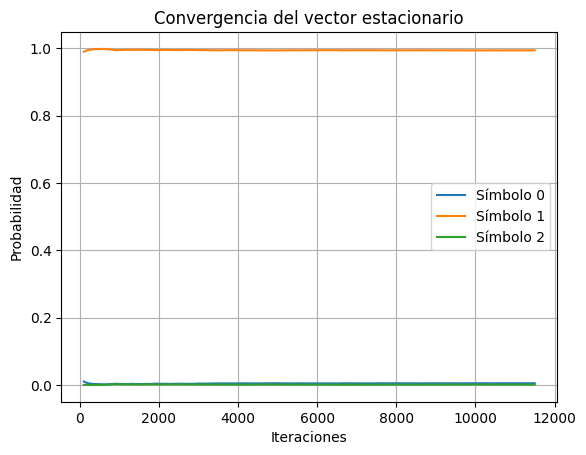

MELBOURNE
Vector estacionario:  [0.031 0.507 0.462]


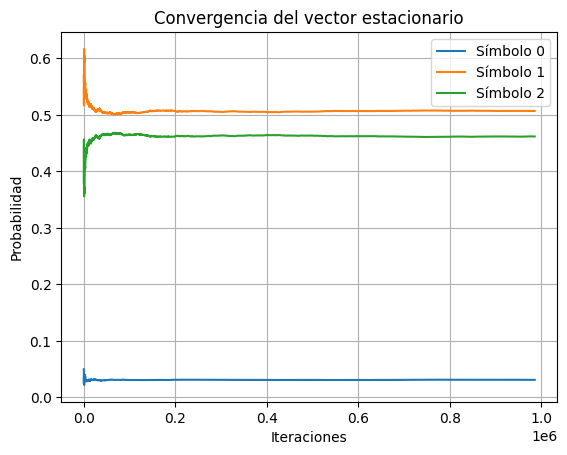

OSLO
Vector estacionario:  [0.686 0.28  0.034]


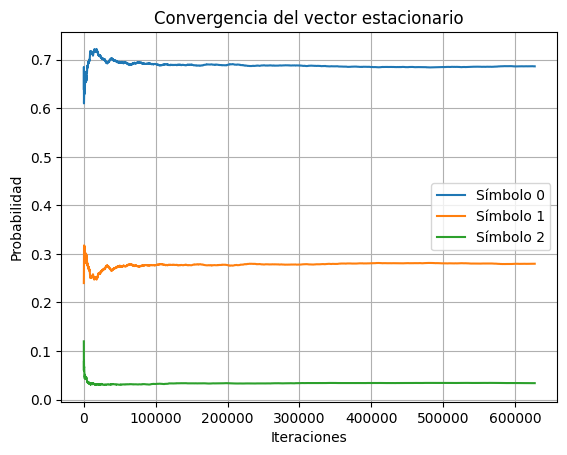

In [21]:
def get_vector_estacionario(matriz_transicion_acumulada, nro_simbolos=NRO_SIMBOLOS, epsilon=0.0000005, min_iteraciones=10000):

    apariciones = np.zeros(nro_simbolos)
    vector_estacionario = np.zeros(nro_simbolos)
    vector_estacionario_anterior = np.full(nro_simbolos, -1)

    simbolo = None
    iteraciones = 0

    # Se guarda el historial para graficar.
    historial_iteraciones = []
    historial = [[] for _ in range(nro_simbolos)]

    while (not converge(vector_estacionario, vector_estacionario_anterior, epsilon) or (iteraciones < min_iteraciones)):

        simbolo = get_siguiente(simbolo, nro_simbolos, matriz_transicion_acumulada)
        iteraciones += 1

        apariciones[simbolo] += 1
        vector_estacionario_anterior = vector_estacionario.copy()
        vector_estacionario = np.array([ aparicion / iteraciones for aparicion in apariciones ])

        # Cada 100 iteraciones, se añade a cada símbolo la probabilidad hallada.
        # Esto con fines de poder realizar el diagrama de convergencia.
        if iteraciones % 100 == 0:
            for i in range(nro_simbolos):
                historial[i].append(vector_estacionario[i])
            historial_iteraciones.append(iteraciones)

    return vector_estacionario, historial, historial_iteraciones

vector_estacionario_quito, historial_quito, iteraciones_quito = get_vector_estacionario(matriz_acumulada_quito)
vector_estacionario_melbourne, historial_melbourne, iteraciones_melbourne = get_vector_estacionario(matriz_acumulada_melbourne)
vector_estacionario_oslo, historial_oslo, iteraciones_oslo = get_vector_estacionario(matriz_acumulada_oslo)

print("QUITO")
print("Vector estacionario: ", vector_estacionario_quito.round(3))
mostrar_grafico_convergencia(historial_quito, iteraciones_quito)
print("MELBOURNE")
print("Vector estacionario: ", vector_estacionario_melbourne.round(3))
mostrar_grafico_convergencia(historial_melbourne, iteraciones_melbourne)
print("OSLO")
print("Vector estacionario: ", vector_estacionario_oslo.round(3))
mostrar_grafico_convergencia(historial_oslo, iteraciones_oslo)


Se experimentó con distintos números de e

De los vectores estacionarios, es posible obtener que:

- 

### El tiempo medio de 1° recurrencia.

In [17]:
def obtener_medias_primera_recurrencia(matriz_transicion_acumulada, nro_simbolos, epsilon=0.0005, min_iteraciones=100000):
    
    pasos = [0] * nro_simbolos # np.zeros(nro_simbolos)
    ocurrencias = [0] * nro_simbolos # np.zeros(nro_simbolos)
    medias_recurrencia = [0] * nro_simbolos # np.zeros(nro_simbolos)
    t_ultima_ocurrencia = [-1] * nro_simbolos # np.full(nro_simbolos, -1)
    medias_recurrencia_anterior = [-1] * nro_simbolos # np.full(nro_simbolos, -1)
    
    t_actual = 0

    simbolo = None
	
    while (not converge(medias_recurrencia, medias_recurrencia_anterior, epsilon) or (t_actual < min_iteraciones)):

        simbolo = get_siguiente(simbolo, nro_simbolos, matriz_transicion_acumulada)

        # Si la señal ya apareció al menos una vez...
        if (t_ultima_ocurrencia[simbolo] >= 0):
            # Se suma la cantidad de pasos desde la última ocurrencia.
            pasos[simbolo] += t_actual - t_ultima_ocurrencia[simbolo]
            ocurrencias[simbolo] += 1

        t_ultima_ocurrencia[simbolo] = t_actual
        t_actual += 1

        # Se actualiza la media de primera recurrencia del símbolo.
        medias_recurrencia_anterior[simbolo] = medias_recurrencia[simbolo]
        if (ocurrencias[simbolo] > 0):
            medias_recurrencia[simbolo] = pasos[simbolo] / ocurrencias[simbolo]
        
    return [round(x,3) for x in medias_recurrencia]
	
print("Medias de primera recurrencia:")
medias_primera_recurrencia_quito = obtener_medias_primera_recurrencia(matriz_acumulada_quito, 3)
print("Quito:", medias_primera_recurrencia_quito)
medias_primera_recurrencia_melbourne = obtener_medias_primera_recurrencia(matriz_acumulada_melbourne, 3)
print("Melbourne:", medias_primera_recurrencia_melbourne)
medias_primera_recurrencia_oslo = obtener_medias_primera_recurrencia(matriz_acumulada_oslo, 3)
print("Oslo:", medias_primera_recurrencia_oslo)

Medias de primera recurrencia:
Quito: [159.736, 1.007, 1457.038]
Melbourne: [33.35, 1.991, 2.138]
Oslo: [1.452, 3.603, 29.478]


Media de recurrencia → Tiempo medio de espera para volver a emitir un símbolo.

# Parte 3: Entropía, Huffman y la batalla por los bits

## 1. Calcular la entropía de cada fuente Ti :

### a. Sin memoria (orden 0), considerando símbolos individuales.

In [18]:
def get_entropia_sin_memoria(vector_estacionario):
    nro_simbolos = len(vector_estacionario)
    h = 0
    for i in range(nro_simbolos):
        if vector_estacionario[i] != 0:
            h += vector_estacionario[i] * np.log2(vector_estacionario[i])
    return round(-h, 3)

entropia_melbourne = get_entropia_sin_memoria(vector_estacionario_melbourne)
entropia_quito = get_entropia_sin_memoria(vector_estacionario_quito)
entropia_oslo = get_entropia_sin_memoria(vector_estacionario_oslo)
print("Entropía sin memoria para Melbourne: ", entropia_melbourne)
print("Entropía sin memoria para Quito: ", entropia_quito)
print("Entropía sin memoria para Oslo: ", entropia_oslo)

Entropía sin memoria para Melbourne:  1.167
Entropía sin memoria para Quito:  0.064
Entropía sin memoria para Oslo:  1.057


### b. Con memoria (orden 1), usando información sobre transiciones entre símbolos.

In [19]:
def get_entropia_con_memoria(matriz_transicion, vector_estacionario, nro_simbolos=3):
    hcond = 0
    for i in range(nro_simbolos):
        hi = 0
        for j in range(nro_simbolos):
            if matriz_transicion[j][i] != 0:
                hi += matriz_transicion[j][i] * np.log2(matriz_transicion[j][i])
        hcond += vector_estacionario[i] * (-hi)
    return round(hcond, 3)

entropia_cond_melbourne = get_entropia_con_memoria(matriz_transicion_melbourne, vector_estacionario_melbourne)
entropia_cond_quito = get_entropia_con_memoria(matriz_transicion_quito, vector_estacionario_quito)
entropia_cond_oslo = get_entropia_con_memoria(matriz_transicion_oslo, vector_estacionario_oslo)
print("Entropía con memoria para Melbourne: ", entropia_cond_melbourne)
print("Entropía con memoria para Quito: ", entropia_cond_quito)
print("Entropía con memoria para Oslo: ", entropia_cond_oslo)

Entropía con memoria para Melbourne:  0.691
Entropía con memoria para Quito:  0.063
Entropía con memoria para Oslo:  0.39


### Interpretar los resultados: ¿Qué ciudad presenta menor entropía? ¿Cuál más? ¿Esto hace que alguna ciudad sea más impredecible que otra?

A la mayor entropía la presenta Melbourne. Con una entropía cercana, se halla Oslo. Quito tiene la menor entropía, lo cual es coherente con su descripción:

## 2. Implementar el algoritmo de Huffman para codificar cada señal Ti  y su extensión a orden 2, teniendo en cuenta que la fuente es markoviana. Aplicar el Teorema de Shannon y analizar resultados.

In [20]:
def get_fuente(vector_estacionario):
    fuente = {
        'F' : vector_estacionario[0],
        'T' : vector_estacionario[1],
        'C' : vector_estacionario[2]
    }
    return fuente

fuente_melbourne = get_fuente(vector_estacionario_melbourne)
fuente_quito = get_fuente(vector_estacionario_quito)
fuente_oslo = get_fuente(vector_estacionario_oslo)

In [21]:
def reemplazar(fuente):
    out = {}
    remplazo = {}
    letra = '@'
    for(key, value) in fuente.items():
        letra = chr(ord(letra) + 1)
        out.update({letra : value})
        remplazo.update({letra : key})
    return out , remplazo

def extender(fuente, remplazo):
    out = {}
    for(key, value) in fuente.items():
        out.update({remplazo[key] : value})
    return out

In [22]:
def get_fuente_orden2(vector_estacionario, matriz_transicion): 
    fuente = {
        0 : 'F',
        1 : 'T',
        2 : 'C'
    }
    fuente2 = {}
    for i in range(3):
        for j in range(3):
            p = vector_estacionario[i] * matriz_transicion[j][i]
            if p != 0:
                fuente2.update({fuente[i] + fuente[j] : p})
    return fuente2

orden2_melbourne_aux , remplazo_melbourne = reemplazar(get_fuente_orden2(vector_estacionario_melbourne, matriz_transicion_melbourne))
orden2_quito_aux, remplazo_quito = reemplazar(get_fuente_orden2(vector_estacionario_quito, matriz_transicion_quito))
orden2_oslo_aux, remplazo_oslo = reemplazar(get_fuente_orden2(vector_estacionario_oslo, matriz_transicion_oslo))
print("Fuente de orden 2  para Melborne: ",orden2_melbourne_aux)
print("Fuente de orden 2  para Quito: ",orden2_quito_aux)
print("Fuente de orden 2  para Oslo: ",orden2_oslo_aux)

Fuente de orden 2  para Melborne:  {'A': 0.015076502732240437, 'B': 0.015923497267759563, 'C': 0.016147823152210597, 'D': 0.42585588930138374, 'E': 0.06699628754640567, 'F': 0.06651835372636264, 'G': 0.3934816462736374}
Fuente de orden 2  para Quito:  {'A': 0.00032432432432432436, 'B': 0.005675675675675676, 'C': 0.0059901758014477766, 'D': 0.9863252326783868, 'E': 0.0006845915201654602, 'F': 0.001}
Fuente de orden 2  para Oslo:  {'A': 0.6551816591704148, 'B': 0.02781834082958521, 'C': 0.028041945288753794, 'D': 0.2449799392097264, 'E': 0.009978115501519755, 'F': 0.01006122448979592, 'G': 0.023938775510204083}


In [23]:
def get_codificacion_huffman(fuente):
    copia = fuente.copy()
    out = {}
    prob_obtenida = 0

    # El round() es necesario puesto a que, al no trabjar con números exactos, a veces se producen errores de redondeo,
    # tal y como que la suma da 0.9999... y entonces el while itera una vez más de lo que debería.
    while prob_obtenida <= 0.99:
        copia = dict(sorted(copia.items(), key=lambda x: x[1], reverse=True))
        ultimo = list(copia.items())[-1]
        anteultimo = list(copia.items())[-2]
        for char in list(anteultimo[0]):
            out[char] = '1' + str(out.get(char,''))
        for char in list(ultimo[0]):
            out[char] = '0' + str(out.get(char,''))
        prob_obtenida = (ultimo[1] + anteultimo[1])
        del copia[ultimo[0]]
        del copia[anteultimo[0]]
        copia.update({ultimo[0] + anteultimo[0] : prob_obtenida})
    
    return out

huffman_melbourne = get_codificacion_huffman(fuente_melbourne)
huffman_quito = get_codificacion_huffman(fuente_quito)
huffman_oslo = get_codificacion_huffman(fuente_oslo)
huffman_melbourne2_aux = get_codificacion_huffman(orden2_melbourne_aux)
huffman_quito2_aux = get_codificacion_huffman(orden2_quito_aux)
huffman_oslo2_aux = get_codificacion_huffman(orden2_oslo_aux)
print("Codificación Huffman para Melbourne: ",huffman_melbourne)
print("Codificación Huffman para Quito: ",huffman_quito)
print("Codificación Huffman para Oslo: ",huffman_oslo)
print("Codificación Huffman para orden 2 de Melbourne: ",huffman_melbourne2_aux)
print("Codificación Huffman para orden 2 de Quito: ",huffman_quito2_aux)
print("Codificación Huffman para orden 2 de Oslo: ",huffman_oslo2_aux)  

Codificación Huffman para Melbourne:  {'C': '01', 'F': '00', 'T': '1'}
Codificación Huffman para Quito:  {'F': '01', 'C': '00', 'T': '1'}
Codificación Huffman para Oslo:  {'T': '01', 'C': '00', 'F': '1'}
Codificación Huffman para orden 2 de Melbourne:  {'B': '101011', 'A': '101010', 'C': '10100', 'F': '1011', 'E': '100', 'G': '11', 'D': '0'}
Codificación Huffman para orden 2 de Quito:  {'E': '01011', 'A': '01010', 'F': '0100', 'B': '011', 'C': '00', 'D': '1'}
Codificación Huffman para orden 2 de Oslo:  {'F': '00001', 'E': '00000', 'G': '0001', 'C': '0011', 'B': '0010', 'D': '01', 'A': '1'}


In [24]:
orden2_melbourne = extender(orden2_melbourne_aux, remplazo_melbourne)
orden2_quito = extender(orden2_quito_aux, remplazo_quito)
orden2_oslo = extender(orden2_oslo_aux, remplazo_oslo)

huffman_melbourne2 = extender(huffman_melbourne2_aux, remplazo_melbourne)
huffman_quito2 = extender(huffman_quito2_aux, remplazo_quito)
huffman_oslo2 = extender(huffman_oslo2_aux, remplazo_oslo)

print(huffman_quito2)

{'TC': '01011', 'FF': '01010', 'CT': '0100', 'FT': '011', 'TF': '00', 'TT': '1'}


## 3. En cada caso, calcular la longitud total del mensaje codificado (en bits), compararla con la longitud original del archivo y obtener la tasa de compresión.

In [25]:
def get_longitud_media(codigo_huffman,probabilidades):
    L = 0
    for key, value in codigo_huffman.items():
        L += len(value) * probabilidades[key]
    return L

longitud_media_melbourne = get_longitud_media(huffman_melbourne, fuente_melbourne)
longitud_media_quito = get_longitud_media(huffman_quito, fuente_quito)
longitud_media_oslo = get_longitud_media(huffman_oslo, fuente_oslo)
longitud_media_melbourne2 = get_longitud_media(huffman_melbourne2, orden2_melbourne)
longitud_media_quito2 = get_longitud_media(huffman_quito2, orden2_quito)
longitud_media_oslo2 = get_longitud_media(huffman_oslo2, orden2_oslo)
print("Longitud media para Melbourne: ",longitud_media_melbourne)
print("Longitud media para Quito: ",longitud_media_quito)
print("Longitud media para Oslo: ",longitud_media_oslo)
print("Longitud media para orden 2 de Melbourne: ",longitud_media_melbourne2)
print("Longitud media para orden 2 de Quito: ",longitud_media_quito2)
print("Longitud media para orden 2 de Oslo: ",longitud_media_oslo2)

Longitud media para Melbourne:  1.491
Longitud media para Quito:  1.007
Longitud media para Oslo:  1.317
Longitud media para orden 2 de Melbourne:  1.946620575154379
Longitud media para orden 2 de Quito:  1.0243771905307584
Longitud media para orden 2 de Oslo:  1.5645344840606183


In [26]:
def get_limites_shannon(h,hcond,n):
    lim_inferior = h/n + ((1 - 1/n) * hcond)
    lim_superior = lim_inferior + 1/n
    return lim_inferior, lim_superior

limite_inferior_melbourne, limite_superior_melbourne = get_limites_shannon(entropia_melbourne, entropia_cond_melbourne, 1)
limite_inferior_quito, limite_superior_quito = get_limites_shannon(entropia_quito, entropia_cond_quito, 1)
limite_inferior_oslo, limite_superior_oslo = get_limites_shannon(entropia_oslo, entropia_cond_oslo, 1)
limite_inferior_melbourne2, limite_superior_melbourne2 = get_limites_shannon(entropia_melbourne, entropia_cond_melbourne, 2)
limite_inferior_quito2, limite_superior_quito2 = get_limites_shannon(entropia_quito, entropia_cond_quito, 2)
limite_inferior_oslo2, limite_superior_oslo2 = get_limites_shannon(entropia_oslo, entropia_cond_oslo, 2)
print("Shannon para Melbourne orden 1: ")
print(limite_inferior_melbourne, " <= ", longitud_media_melbourne, " < ", limite_superior_melbourne)
print("Shannon para Quito orden 1: ")
print(limite_inferior_quito, " <= ", longitud_media_quito, " < ", limite_superior_quito)
print("Shannon para Oslo orden 1: ")
print(limite_inferior_oslo, " <= ", longitud_media_oslo, " < ", limite_superior_oslo)
print("Shannon para Melbourne orden 2: ")
print(limite_inferior_melbourne2, " <= ", longitud_media_melbourne2/2, " < ", limite_superior_melbourne2)
print("Shannon para Quito orden 2: ")
print(limite_inferior_quito2, " <= ", longitud_media_quito2/2, " < ", limite_superior_quito2)
print("Shannon para Oslo orden 2: ")
print(limite_inferior_oslo2, " <= ", longitud_media_oslo2/2, " < ", limite_superior_oslo2)

Shannon para Melbourne orden 1: 
1.167  <=  1.491  <  2.167
Shannon para Quito orden 1: 
0.064  <=  1.007  <  1.064
Shannon para Oslo orden 1: 
1.057  <=  1.317  <  2.057
Shannon para Melbourne orden 2: 
0.929  <=  0.9733102875771895  <  1.429
Shannon para Quito orden 2: 
0.0635  <=  0.5121885952653792  <  0.5635
Shannon para Oslo orden 2: 
0.7235  <=  0.7822672420303092  <  1.2235


Asumiendo que los símbolos enviados originalmente son codificados

In [27]:
def get_fuente_pares(dataset_discreto):
    out = pd.DataFrame(columns = ["Par"])
    for i in range((len(dataset_discreto)//2)):
        out.loc[i] = [dataset_discreto["AvgTemperature"][i*2] + dataset_discreto["AvgTemperature"][i*2+1]]
    return out

def get_values_and_counts(dataset):
    values, counts = np.unique(dataset, return_counts=True)
    # Se retorna un diccionario que asocia a cada valor único su número de apariciones.
    return dict(zip(values, counts))

def obtener_tasa_comprension(original_dataset, discrete_dataset, huffman_codification):

    original_count = get_values_and_counts(original_dataset)
    discrete_count = get_values_and_counts(discrete_dataset)

    bits_originales = 0
    for (value, count) in original_count.items():
        # Cantidad de bits que deben usarse para almacenar el valor por su número de apariciones.
        bits_originales += len(bin(int(value))[2:]) * count

    bits_codificados = 0
    for (value, count) in discrete_count.items():
        # Cantidad de bits que deben usarse para almacenar el valor por su número de apariciones.
        bits_codificados += len(huffman_codification[value]) * count

    tasa_comprension = bits_originales / bits_codificados
    return bits_originales, bits_codificados, tasa_comprension

print("COMPRENSIONES DE ORDEN 1:")
bits_originales_melbourne, bits_codificados_melbourne, tasa_comprension_melbourne = obtener_tasa_comprension(cleaned_dataset_melbourne, discrete_melbourne_dataset["AvgTemperature"], huffman_melbourne)
bits_originales_quito, bits_codificados_quito, tasa_comprension_quito = obtener_tasa_comprension(dataset_raw_quito, discrete_quito_dataset["AvgTemperature"], huffman_quito)
bits_originales_oslo, bits_codificados_oslo, tasa_comprension_oslo = obtener_tasa_comprension(cleaned_dataset_oslo, discrete_oslo_dataset["AvgTemperature"], huffman_oslo)
print("\nTasa de comprensión para Melbourne: ",tasa_comprension_melbourne)
print(f"En lugar de utilizarse {bits_originales_melbourne} bits, se utilizan {bits_codificados_melbourne} bits.")
print("\nTasa de comprensión para Quito: ",tasa_comprension_quito)
print(f"En lugar de utilizarse {bits_originales_quito} bits, se utilizan {bits_codificados_quito} bits.")
print("\nTasa de comprensión para Oslo: ",tasa_comprension_oslo)
print(f"En lugar de utilizarse {bits_originales_oslo} bits, se utilizan {bits_codificados_oslo} bits.")

print("\nCOMPRENSIONES DE ORDEN 2:")
bits_originales_melbourne, bits_codificados_melbourne, tasa_comprension_melbourne = obtener_tasa_comprension(cleaned_dataset_melbourne, get_fuente_pares(discrete_melbourne_dataset), huffman_melbourne2)
bits_originales_quito, bits_codificados_quito, tasa_comprension_quito = obtener_tasa_comprension(dataset_raw_quito, get_fuente_pares(discrete_quito_dataset), huffman_quito2)
bits_originales_oslo, bits_codificados_oslo, tasa_comprension_oslo = obtener_tasa_comprension(cleaned_dataset_oslo, get_fuente_pares(discrete_oslo_dataset), huffman_oslo2)
print("\nTasa de comprensión para Melbourne: ",tasa_comprension_melbourne)
print(f"En lugar de utilizarse {bits_originales_melbourne} bits, se utilizan {bits_codificados_melbourne} bits.")
print("\nTasa de comprensión para Quito: ",tasa_comprension_quito)
print(f"En lugar de utilizarse {bits_originales_quito} bits, se utilizan {bits_codificados_quito} bits.")
print("\nTasa de comprensión para Oslo: ",tasa_comprension_oslo)
print(f"En lugar de utilizarse {bits_originales_oslo} bits, se utilizan {bits_codificados_oslo} bits.")

COMPRENSIONES DE ORDEN 1:

Tasa de comprensión para Melbourne:  3.1267621776504297
En lugar de utilizarse 27281 bits, se utilizan 8725 bits.

Tasa de comprensión para Quito:  4.037043330501274
En lugar de utilizarse 23758 bits, se utilizan 5885 bits.

Tasa de comprensión para Oslo:  2.6608978529603124
En lugar de utilizarse 20449 bits, se utilizan 7685 bits.

COMPRENSIONES DE ORDEN 2:

Tasa de comprensión para Melbourne:  4.77608543417367
En lugar de utilizarse 27281 bits, se utilizan 5712 bits.

Tasa de comprensión para Quito:  7.953799799129562
En lugar de utilizarse 23758 bits, se utilizan 2987 bits.

Tasa de comprensión para Oslo:  4.449303742384682
En lugar de utilizarse 20449 bits, se utilizan 4596 bits.


# Parte 4: El canal climático de Musk.

Ahora el satélite en órbita (SpaceHeat-42) transmite la señal $S_2$ (de Melbourne)… pero lo que llega a la base terrestre es S4 (Melbourne “ruidoso”), misteriosamente diferente.

In [28]:
def get_matriz_conjunta(matriz_transicion, vector_estacionario, orden=3):
    
    # Se crea una matriz cuadrada de ceros.
    out = np.zeros((orden, orden))

    for i in range(orden):
        for j in range(orden):
            out[i][j] = (matriz_transicion[i][j] * vector_estacionario[j]).round(3)

    return out

matriz_conjunta_melbourne = get_matriz_conjunta(matriz_transicion_melbourne, vector_estacionario_melbourne)
print("Matriz conjunta de Melbourne:\n", matriz_conjunta_melbourne)

Matriz conjunta de Melbourne:
 [[0.015 0.016 0.   ]
 [0.016 0.426 0.067]
 [0.    0.067 0.393]]


Ahora el satélite en órbita (SpaceHeat-42) transmite la señal S2 (de Melbourne)… pero lo que llega a la base terrestre es S4 (Melbourne “ruidoso”), misteriosamente diferente.
Generar T4 (de igual manera igual que se generaron las otras Ti), y construir la matriz de canal comparando T2 (entrada) y T4 (salida).
Calcula el Ruido del canal y la Información mutua. Analizar los valores obtenidos (explicar si es un buen canal o una porquería disfrazada de innovación).

Se obtiene la fuente discreta de T4 y se construye su matriz de transición:

In [29]:
discrete_melbourne_ruidoso_dataset = obtener_fuente_discreta(cleaned_dataset_melbourne_ruidoso)
matriz_transicion_melbourne_ruidoso = get_matriz_transicion(discrete_melbourne_ruidoso_dataset["AvgTemperature"])

print("Matriz de transición de Melbourne:\n", matriz_transicion_melbourne)
print("\nMatriz de transición para Melbourne ruidoso:\n", matriz_transicion_melbourne_ruidoso)

Matriz de transición de Melbourne:
 [[0.4863388  0.0317246  0.        ]
 [0.5136612  0.83665204 0.14460512]
 [0.         0.13162335 0.85539488]]

Matriz de transición para Melbourne ruidoso:
 [[0.3030888  0.12046869 0.01233616]
 [0.63127413 0.57305016 0.3234387 ]
 [0.06563707 0.30648114 0.66422513]]


In [30]:
def get_canal_compuesto(entrada, salida, orden=3, rounding=3):

    # Se crea una matriz llena de ceros, en la que almacenará el canal compuesto.
    out = np.zeros((orden, orden))

    for i in range(orden):
        for j in range(orden):
            suma = 0
            for k in range(orden):
                suma += salida[i][k] * entrada[k][j]
            out[i][j] = round(suma, rounding)

    return out

canal_compuesto = get_canal_compuesto(matriz_transicion_melbourne, matriz_transicion_melbourne_ruidoso)
print(canal_compuesto)

[[0.209 0.112 0.028]
 [0.601 0.542 0.36 ]
 [0.189 0.346 0.612]]


Se tiene un canal, donde la entrada es T2 y T4 es la salida:

In [31]:
def get_ruido(matriz_transicion, vector_estacionario):
    # Hcond = H(Y/X)
    return round(get_entropia_con_memoria(matriz_transicion, vector_estacionario), 3)

ruido_canal_compuesto = get_ruido(canal_compuesto, vector_estacionario_melbourne)
print("Ruido para Melbourne ruidoso: ", ruido_canal_compuesto)

Ruido para Melbourne ruidoso:  1.246


In [32]:
def get_distribucion_salida(matriz_conjunta, orden=3):

    # Arreglo de salida, lleno de ceros.
    out = np.zeros(orden)

    for i in range(orden):
        for j in range(orden):
            # Se suman las filas.
            out[i] += matriz_conjunta[i][j]

    return out.round(3)

# I(X,Y) = H(Y) - H(Y/X)
informacion_mutua = round(get_entropia_sin_memoria(get_distribucion_salida(get_matriz_conjunta(canal_compuesto, vector_estacionario_melbourne))) - ruido_canal_compuesto, 3)
print("Información mutua del canal compuesto: ", informacion_mutua)

Información mutua del canal compuesto:  0.066


In [33]:
# Conjunta de Quito.
print("\nConjunta de Quito:")
print(get_matriz_conjunta(matriz_transicion_quito, vector_estacionario_quito))
# Conjunta de Melbourne.
print("\nConjunta de Melbourne:")
print(get_matriz_conjunta(matriz_transicion_melbourne, vector_estacionario_melbourne))
# Conjunta de Oslo.
print("\nConjunta de Oslo:")
print(get_matriz_conjunta(matriz_transicion_oslo, vector_estacionario_oslo))


Conjunta de Quito:
[[0.    0.006 0.   ]
 [0.006 0.986 0.001]
 [0.    0.001 0.   ]]

Conjunta de Melbourne:
[[0.015 0.016 0.   ]
 [0.016 0.426 0.067]
 [0.    0.067 0.393]]

Conjunta de Oslo:
[[0.655 0.028 0.   ]
 [0.028 0.245 0.01 ]
 [0.    0.01  0.024]]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ebd8bcc-2607-4fac-b013-6f5656f47292' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>